# Distribution of secondary structure content in proteins of the same "proteome"

### Requirements

- numpy
- pandas
- matplotlib
- Python 3.6+

### Data

A _Unitprot text_ file with information on yeast _S. cerevisiae_ proteins. To retrieve this file:

- at UniProt search for _S. cerevisiae_ "proteome" [www.uniprot.org/proteomes/UP000002311](https://www.uniprot.org/proteomes/UP000002311)
- Change to UniProtKB search results in link "Map to Reviewed"
- Download -> Text
- If the downloaded file was "compressed" (a zip file), extract the content.
- Rename the file as `uniprot_scerevisiae_reviewed.txt`


## Data extraction

### Reading of a _UniProt text_ file

In [1]:
data_filename = 'uniprot_scerevisiae_reviewed.txt'

def read_Uniprot_text(filename):
    """Reads a UniProt text file and splits into a list of protein records."""
    
    with open(filename) as uniprot_file:
        whole_file = uniprot_file.read()

    records = whole_file.split('//\n')
    
    # remove empty records
    # records = [p for p in records if len(p) != 0]
    records.pop(-1) # because we know that the empty record is the last one
    return records

prots = read_Uniprot_text(data_filename)

print(f'The number of protein records in "{data_filename}" is {len(prots)}')

The number of protein records in "uniprot_scerevisiae_reviewed.txt" is 6049


### Extraction of information for each protein record

In [2]:
def extract_info(record):
    IDline, ACline, *otherlines = record.splitlines()
    
    # Extract UniProt AC and number of amino acids
    # Example (first two lines):
    # ID   AB140_YEAST             Reviewed;         628 AA.
    # AC   Q08641; D6W2U2; Q08644;
    
    ac = ACline.split()[1].strip(';')
    _, _, _, n, *therest = IDline.split()
    n = int(n) # n must be a number, not a string
    
    # Create "profile" list with codes for secondary structure:
    # - means no SS
    # H, S, T mean each of the SS elements
    # ? means a position not covered by a PDB structure
    
    profile = ['-'] * n
    
    # Grab FT lines and DR   PDB lines
    FTlines = []
    DRPDBlines = []
    
    for line in otherlines:
        if line.startswith('FT'):
            FTlines.append(line)
        elif line.startswith('DR   PDB;'):
            DRPDBlines.append(line)
            
        
    # find secondary-structure FT lines and insert into profile
    # Example (from P03870):
    # FT   ACT_SITE    343    343       O-(3'-phospho-DNA)-tyrosine intermediate.
    # FT   HELIX         3      9       {ECO:0000244|PDB:1FLO}.
    # FT   HELIX        12     24       {ECO:0000244|PDB:1FLO}.
    
    for line in FTlines:
        
        FTcode, ss_name, *therest = line.split()

        if ss_name in ['HELIX', 'STRAND', 'TURN']:
            start, end, *lastparts = therest
            start, end = int(start), int(end)
            # Mark position of secondary structure in profile
            # using the first letter of secondary structure as a code
            code = ss_name[0]
            # UniProt numbering starts at 1
            profile[start-1: end] = code * (end - start + 1)
    
    # PDB structures may not "cover" all of the sequence!
    # Sequence coverage must be found by looking at DR PDB records.
    # Example, P31380:
    # DR   PDB; 5GN1; X-ray; 1.95 A; A/B/C/D=780-1122.
    # In this example, PDB info only covers 780-1122
    
    # Read coverage from "DR PDB" lines
    # mark with 1's the coverage (otherwise 0)
    
    coverage = [0] * n
    
    for line in DRPDBlines:
        
        # Example, Q06489:
        #DR   PDB; 1W2W; X-ray; 1.75 A; A/E/I/M=1-211, B/F/J/N=221-411.
        
        *otherstuff, last = line.split(';')
        
        last_parts = last.split(',')
        # last_parts is now [' A/E/I/M=1-211', ' B/F/J/N=221-411.']
        
        for eq in last_parts:
            left, right = eq.split('=')
            start, end = right.split('-')
            start = int(start)
            end = int(end.strip('.'))
            coverage[start-1: end] = [1] * (end - start + 1)
    
    # Transfer coverage to the ss_profile
    for i, c in enumerate(coverage):
        if c == 0:
            profile[i] = '?'
    
    # Return dictionary of extracted information
    n_h = profile.count('H')
    n_s = profile.count('S')
    n_t = profile.count('T')
    cov = coverage.count(1)
    
    if n_h == 0 and n_s == 0 and n_t == 0:
        cov = 0

    d = {'ac': ac,
         'n': n,
         'cov' : cov,
         'helix': n_h,
         'strand': n_s,
         'turn': n_t,
         'profile': ''.join(profile)
        }
    return d

# Apply to all proteins
all_prots = [extract_info(p) for p in prots]

# Check the first 18
all_prots[:18]

[{'ac': 'Q08641',
  'n': 628,
  'cov': 0,
  'helix': 0,
  'strand': 0,
  'turn': 0,
  'profile': '????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????'},
 {'ac': 'P28240',
  'n': 557,
  'cov': 0,
  'helix': 0,
  'strand': 0,
  'turn': 0,
  'profile': '????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

### Restrict to proteins that have secondary structure annotations

In [3]:
all_prots = [extract_info(p) for p in prots]
ntot = len(prots)

all_prots = [p for p in all_prots if p['cov'] > 0]

fraction_withSS = 100.0 * len(all_prots) / ntot
print('The number of proteins with Sec. structure information is', len(all_prots))
print(f'That is {fraction_withSS:4.1f} % of the total number of proteins.')

The number of proteins with Sec. structure information is 1359
That is 22.5 % of the total number of proteins.


### Transform data into _Data frame_ of package _pandas_

In [4]:
import pandas as pd

In [5]:
sstable = pd.DataFrame(all_prots).set_index('ac')

# change the order of columns
sstable = sstable.reindex(columns=['n', 'cov', 'helix', 'strand', 'turn', 'profile'])

sstable

,n,cov,helix,strand,turn,profile
ac,,,,,,
Q02336,434,200,89,17,10,?------TTT--------SSSSSSS------HHHHH----------...
Q12440,853,74,45,10,3,??????????????????????????????????????????????...
P14904,514,514,176,113,18,HHHHHHHHHHHHHHHHH----------------HHHHHHHHHH-SS...
P49435,187,187,66,58,3,-HHHHHHHHHHHH-SSS---------SSS-HHHHH-HHHHHHHHHH...
P18239,318,318,210,3,6,------------------------HHHHHHHHHHHHHHHHHHHHHH...
Q12449,350,156,42,46,0,----------------HHHHHHHHHHHH---SSS------SSSS--...
Q04894,360,360,99,122,10,--TTT-SSSSSS--SSS----SSSSS--------SSSSSSSSSSS-...
P46680,615,615,3,347,49,---SSSSSSS--------------SSSTTTTSSSSSS--SSSSSS-...
P25335,343,343,30,158,4,-SSS-HHHHHHHHHHHTTTT-------HHH--SSSSSS--SSS-HH...


#### test with a protein (a DataFrame row)

In [6]:
sstable.loc['Q02336']

n                                                        434
cov                                                      200
helix                                                     89
strand                                                    17
turn                                                      10
profile    ?------TTT--------SSSSSSS------HHHHH----------...
Name: Q02336, dtype: object

In [7]:
sstable.loc['Q02336']['profile']

0


'?------TTT--------SSSSSSS------HHHHH-------------SSSS---------SSS-HHHHHHHHHHHHHH----HHHHHHHH----HHHHHHHHHHHTTT-TTTT-----?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????----HHHH-----SSS-HHHHHHHHH----HHHHHHHHHHHHHHHHHH-----HHHHHHH----HHHHHHHHHHHHH----'

## Data Analysis

### Computation of Sec. structure percentages (relative to coverage)

In [8]:
sstable['% cov'] = 100.0 * sstable['cov'] / sstable['n']
sstable['% helix'] = 100.0 * sstable['helix'] / sstable['cov']
sstable['% strand'] = 100.0 * sstable['strand'] / sstable['cov']
sstable['% turn'] = 100.0 * sstable['turn'] / sstable['cov']

sstable

,n,cov,helix,strand,turn,profile,% cov,% helix,% strand,% turn
ac,,,,,,,,,,
Q02336,434,200,89,17,10,?------TTT--------SSSSSSS------HHHHH----------...,46.082949,44.500000,8.500000,5.000000
Q12440,853,74,45,10,3,??????????????????????????????????????????????...,8.675264,60.810811,13.513514,4.054054
P14904,514,514,176,113,18,HHHHHHHHHHHHHHHHH----------------HHHHHHHHHH-SS...,100.000000,34.241245,21.984436,3.501946
P49435,187,187,66,58,3,-HHHHHHHHHHHH-SSS---------SSS-HHHHH-HHHHHHHHHH...,100.000000,35.294118,31.016043,1.604278
P18239,318,318,210,3,6,------------------------HHHHHHHHHHHHHHHHHHHHHH...,100.000000,66.037736,0.943396,1.886792
Q12449,350,156,42,46,0,----------------HHHHHHHHHHHH---SSS------SSSS--...,44.571429,26.923077,29.487179,0.000000
Q04894,360,360,99,122,10,--TTT-SSSSSS--SSS----SSSSS--------SSSSSSSSSSS-...,100.000000,27.500000,33.888889,2.777778
P46680,615,615,3,347,49,---SSSSSSS--------------SSSTTTTSSSSSS--SSSSSS-...,100.000000,0.487805,56.422764,7.967480
P25335,343,343,30,158,4,-SSS-HHHHHHHHHHHTTTT-------HHH--SSSSSS--SSS-HH...,100.000000,8.746356,46.064140,1.166181


#### Display information on the largest protein

In [9]:
max_n = sstable['n'].idxmax()

sstable.loc[max_n]

n                                                        4092
cov                                                      3286
helix                                                    1370
strand                                                    338
turn                                                       70
profile     ----------------------------------------------...
% cov                                                  80.303
% helix                                                41.692
% strand                                              10.2861
% turn                                                2.13025
Name: P36022, dtype: object

### Write results to _csv_ file and read back

This is just for the purpose of illustration of reading and writting CSV files

In [10]:
short_sstable = sstable.drop(columns=['profile'])

short_sstable.to_csv('s_cerevisiae_ss.txt', sep='\t')

In [11]:
sstable = pd.read_csv('s_cerevisiae_ss.txt', sep='\t').set_index('ac')
sstable

,n,cov,helix,strand,turn,% cov,% helix,% strand,% turn
ac,,,,,,,,,
Q02336,434,200,89,17,10,46.082949,44.500000,8.500000,5.000000
Q12440,853,74,45,10,3,8.675264,60.810811,13.513514,4.054054
P14904,514,514,176,113,18,100.000000,34.241245,21.984436,3.501946
P49435,187,187,66,58,3,100.000000,35.294118,31.016043,1.604278
P18239,318,318,210,3,6,100.000000,66.037736,0.943396,1.886792
Q12449,350,156,42,46,0,44.571429,26.923077,29.487179,0.000000
Q04894,360,360,99,122,10,100.000000,27.500000,33.888889,2.777778
P46680,615,615,3,347,49,100.000000,0.487805,56.422764,7.967480
P25335,343,343,30,158,4,100.000000,8.746356,46.064140,1.166181


## Plots

In [12]:
%matplotlib inline
from matplotlib import pyplot as pl

import seaborn as sns
sns.set(style="ticks")

### Scatter plot

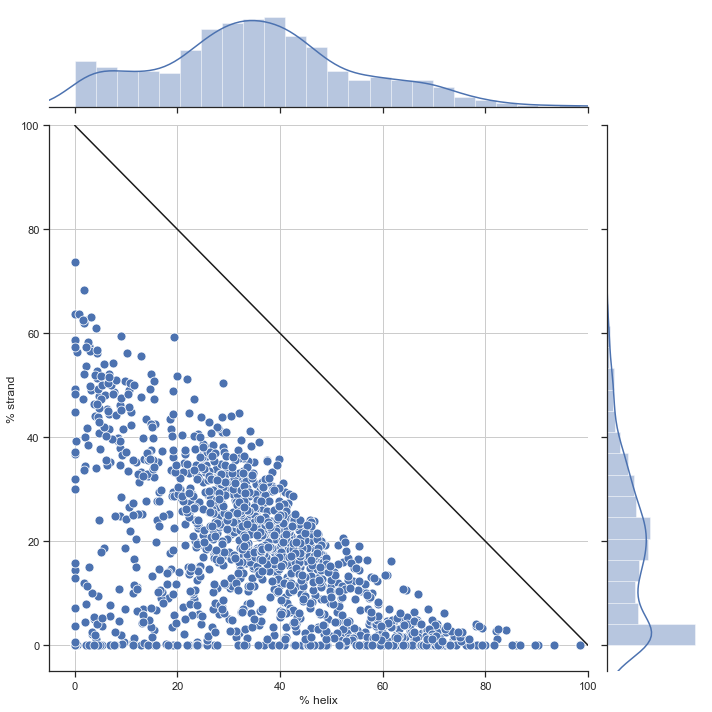

In [13]:
g = sns.JointGrid(x='% helix', y='% strand', data=sstable, height=10, xlim=(-5,100), ylim=(-5,100))

g = g.plot_joint(sns.scatterplot, edgecolor="white", s=80)
g.ax_joint.plot([0, 100], [100, 0], 'k-')
g.ax_joint.grid(True)

g = g.plot_marginals(sns.distplot)

### _Hexplot_

For docs on colormaps, visit [matplotlib.org/3.1.0/tutorials/colors/colormaps.html](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

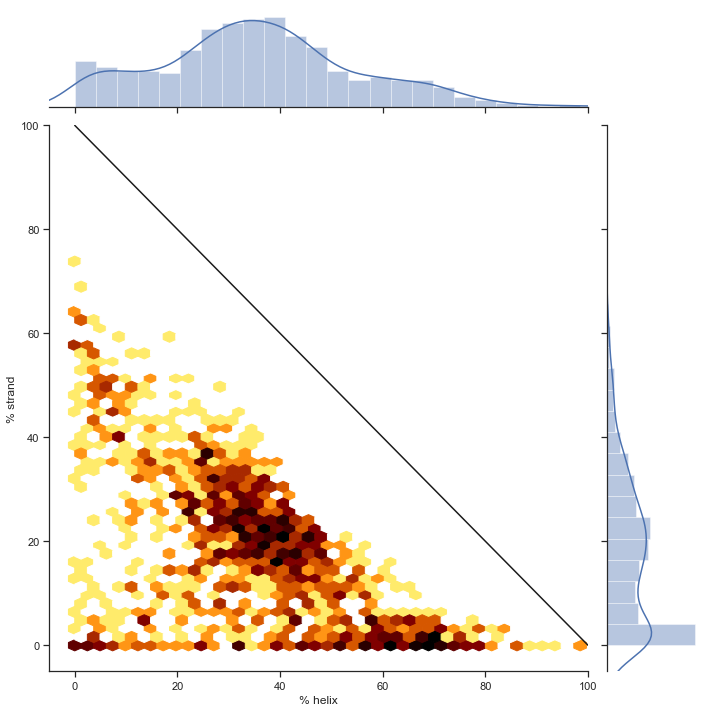

In [14]:
g = sns.JointGrid(x='% helix', y='% strand', data=sstable, height=10, xlim=(-5,100), ylim=(-5,100))

g = g.plot_joint(pl.hexbin, gridsize=40, bins='log', cmap='afmhot_r')

g.ax_joint.plot([0, 100], [100, 0], 'k-')

g = g.plot_marginals(sns.distplot)

### _Kernel density estimate plot_ 

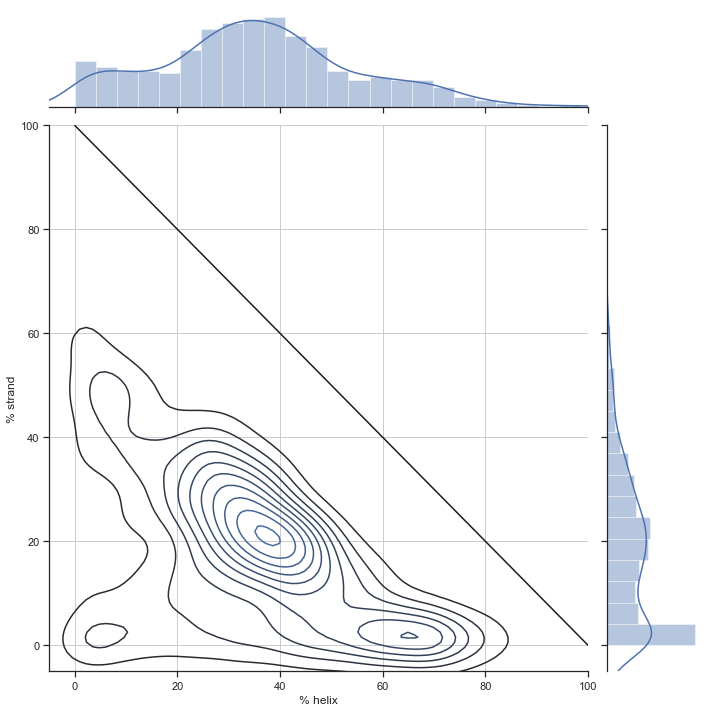

In [15]:
g = sns.JointGrid(x='% helix', y='% strand', data=sstable, height=10, xlim=(-5,100), ylim=(-5,100))

g = g.plot_joint(sns.kdeplot)

g.ax_joint.plot([0, 100], [100, 0], 'k-')
g.ax_joint.grid(True)

g = g.plot_marginals(sns.distplot)

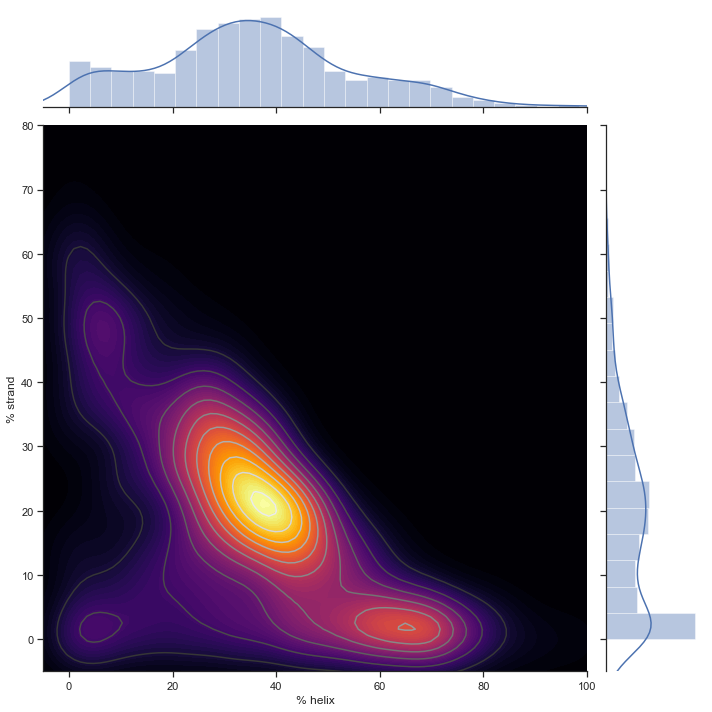

In [16]:
g = sns.JointGrid(x='% helix', y='% strand', data=sstable, height=10, xlim=(-5,100), ylim=(-5,80))

g = g.plot_joint(sns.kdeplot, n_levels=10, color='w')

g = g.plot_joint(sns.kdeplot, cmap='inferno', n_levels=100, shade=True)

g = g.plot_marginals(sns.distplot)